# Step 2: Training a Micro𝕊plit Model for JUMP Dataset

## Introduction - what does this notebook do?

Note: Despite network training arguably being the most important step, the execution of this notebook is optional. If you do not run this notebook, in a later prediction step we can use pretrained model checkpoints.

Below, we will train a Micro𝕊plit network for unmixing two superimposed channels from the JUMP dataset. You'll need to have completed the previous steps:
1. Data preparation (00JUMP_microsplit)
2. Noise model creation (01JUMP_noisemodels)

This notebook is adapted from the original `01_train.ipynb` for HT_LIF24 dataset but uses the custom JUMP dataset-specific scripts to handle our string-based channel selection flexibility.

## Background: what is Micro𝕊plit training all about?

Training is done in a supervised way. For every input patch, we have the two corresponding target patches using which we train our MicroSplit. Besides the primary input patch, we also feed LC inputs to MicroSplit, which enable the network to understand the global spatial context around the input patch.

To enable unsupervised denoising, we integrated the KL loss formulation and Noise models from previous work. The loss function for MicroSplit is a weighted average of denoiSplit loss and μSplit loss.

Let's begin training a Micro𝕊plit model on the JUMP dataset!

In [8]:
# Import standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
from pathlib import Path

# Import deep learning frameworks
import torch
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning import Trainer

# Import CAREamics components
from careamics.lightning import VAEModule
from careamics.lvae_training.dataset import DataSplitType

# Import microsplit reproducibility components
from microsplit_reproducibility.configs.factory import (
    create_algorithm_config,
    get_likelihood_config,
    get_loss_config,
    get_model_config,
    get_optimizer_config,
    get_training_config,
    get_lr_scheduler_config,
)
from microsplit_reproducibility.utils.callbacks import get_callbacks
from microsplit_reproducibility.utils.io import load_checkpoint, load_checkpoint_path
from microsplit_reproducibility.datasets import create_train_val_datasets
from microsplit_reproducibility.utils.utils import (
    plot_training_metrics,
    plot_input_patches,
    plot_training_outputs,
)

# dataset specific modules
from microsplit_reproducibility.configs.parameters.JUMP import get_microsplit_parameters
from microsplit_reproducibility.configs.data.JUMP import get_data_configs
from microsplit_reproducibility.datasets.JUMP import get_train_val_data

In [9]:
def verify_dataset_structure(dataset_dir, channel_list): # move to dataset specific scripts
    """
    Verify that the dataset directory has the expected structure with all required channels.
    
    Parameters
    ----------
    dataset_dir : str
        Path to the dataset directory
    channel_list : list
        List of channel names to verify
        
    Returns
    -------
    bool
        True if all required directories and files exist, False otherwise
    """
    # Check that the main directory exists
    if not os.path.exists(dataset_dir):
        print(f"ERROR: Dataset directory '{dataset_dir}' does not exist!")
        return False
    
    # Check that all channel directories exist
    for channel in channel_list:
        channel_dir = os.path.join(dataset_dir, channel)
        if not os.path.exists(channel_dir):
            print(f"ERROR: Channel directory '{channel_dir}' does not exist!")
            return False
    
    # Check that the combined directory exists
    combined_dir = os.path.join(dataset_dir, "combined")
    if not os.path.exists(combined_dir):
        print(f"ERROR: Combined channel directory '{combined_dir}' does not exist!")
        return False
    
    # Count files in each directory to ensure consistency
    file_counts = {}
    for channel in channel_list + ["combined"]:
        channel_dir = os.path.join(dataset_dir, channel)
        files = [f for f in os.listdir(channel_dir) if f.endswith('.tif')]
        file_counts[channel] = len(files)
    
    # Check that all directories have the same number of files
    if len(set(file_counts.values())) != 1:
        print(f"WARNING: Channel directories have different file counts: {file_counts}")
        return False
    
    return True

In [10]:
def verify_noise_models(noise_models_dir, channel_list):  # move to dataset specific scripts
    """
    Verify that noise models exist for all channels.
    
    Parameters
    ----------
    noise_models_dir : str
        Path to the noise models directory
    channel_list : list
        List of channel names to verify
        
    Returns
    -------
    bool
        True if all required noise models exist, False otherwise
    """
    if not os.path.exists(noise_models_dir):
        print(f"ERROR: Noise models directory '{noise_models_dir}' does not exist!")
        return False
    
    for channel in channel_list:
        noise_model_path = os.path.join(noise_models_dir, f"noise_model_{channel}.npz")
        if not os.path.exists(noise_model_path):
            print(f"ERROR: Noise model '{noise_model_path}' does not exist!")
            return False
    
    return True

In [11]:
def get_unnormalized_predictions(model, dataset, channel_list, mmse_count=10, batch_size=8, num_workers=4, grid_size=32):  # move to dataset specific scripts
    """
    Generate predictions for the entire dataset using the trained model.
    
    Parameters
    ----------
    model : VAEModule
        Trained μSplit model
    dataset : Dataset
        Dataset to generate predictions for
    channel_list : list
        List of channel names
    mmse_count : int
        Number of samples to use for MMSE estimation
    batch_size : int
        Batch size for prediction
    num_workers : int
        Number of worker processes for data loading
    grid_size : int
        Grid size for tiled prediction
        
    Returns
    -------
    tuple
        (predictions, normalized_predictions, standard_deviations)
    """
    from tqdm import tqdm
    
    # Set model to evaluation mode
    model.eval()
    
    # Create dataloader for prediction
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False
    )
    
    # Get data statistics for normalization
    data_stats = dataset.data_stats if hasattr(dataset, 'data_stats') else None
    
    # Prepare containers for predictions
    all_predictions = []
    all_normalized_predictions = []
    all_stds = []
    
    # Generate predictions
    print("Predicting tiles:")
    with torch.no_grad():
        for batch in tqdm(dataloader):
            # Handle different batch formats
            if isinstance(batch, tuple) and len(batch) == 2:
                inputs, targets = batch
            else:
                inputs = batch
            
            # Move to device
            if isinstance(inputs, torch.Tensor):
                inputs = inputs.to(model.device)
            
            # Generate predictions with multiple samples for MMSE
            batch_predictions = []
            for _ in range(mmse_count):
                pred_batch, _ = model(inputs)
                batch_predictions.append(pred_batch.cpu().numpy())
            
            # Calculate MMSE and standard deviation
            batch_predictions = np.stack(batch_predictions, axis=1)
            mmse_prediction = np.mean(batch_predictions, axis=1)
            std_prediction = np.std(batch_predictions, axis=1)
            
            # Store predictions
            all_predictions.append(mmse_prediction)
            all_normalized_predictions.append(mmse_prediction)  # We'll denormalize later if needed
            all_stds.append(std_prediction)
    
    # Concatenate predictions
    predictions = np.concatenate(all_predictions, axis=0)
    norm_predictions = np.concatenate(all_normalized_predictions, axis=0)
    stds = np.concatenate(all_stds, axis=0)
    
    # Reshape if needed
    if len(dataset) == 1:
        predictions = predictions[0]
        norm_predictions = norm_predictions[0]
        stds = stds[0]
    
    return predictions, norm_predictions, stds

def get_target(dataset):
    """Extract target channels from the dataset."""
    return dataset._data[..., :-1]

def get_input(dataset):
    """Extract input (combined) channel from the dataset."""
    return dataset._data[..., -1]

In [12]:
def visualize_predictions(prediction, target, input_image, channel_list):
    """
    Visualize predictions alongside targets and input.
    
    Parameters
    ----------
    prediction : numpy.ndarray
        Predicted channel data
    target : numpy.ndarray
        Target channel data
    input_image : numpy.ndarray
        Input (combined) image
    channel_list : list
        List of channel names
        
    Returns
    -------
    matplotlib.figure.Figure
        Figure with visualizations
    """
    num_channels = prediction.shape[-1]
    assert num_channels == len(channel_list), "Number of channels in prediction doesn't match channel list"
    
    # Create figure
    fig, axes = plt.subplots(num_channels, 3, figsize=(15, 5 * num_channels))
    
    # Handle single channel case
    if num_channels == 1:
        axes = axes.reshape(1, -1)
    
    # Plot each channel
    for ch_idx in range(num_channels):
        # Input image (same for all channels)
        axes[ch_idx, 0].imshow(input_image)
        axes[ch_idx, 0].set_title(f"Input (Combined Channels)")
        axes[ch_idx, 0].axis('off')
        
        # Target for this channel
        vmin = min(target[..., ch_idx].min(), prediction[..., ch_idx].min())
        vmax = max(target[..., ch_idx].max(), prediction[..., ch_idx].max())
        
        axes[ch_idx, 1].imshow(target[..., ch_idx], vmin=vmin, vmax=vmax)
        axes[ch_idx, 1].set_title(f"Target: {channel_list[ch_idx]}")
        axes[ch_idx, 1].axis('off')
        
        # Prediction for this channel
        axes[ch_idx, 2].imshow(prediction[..., ch_idx], vmin=vmin, vmax=vmax)
        axes[ch_idx, 2].set_title(f"Prediction: {channel_list[ch_idx]}")
        axes[ch_idx, 2].axis('off')
    
    plt.tight_layout()
    
    return fig

In [13]:
"""
### JUMPDataset Class
"""

class JUMPDataset(Dataset):  # move to dataset specific scripts
    """
    Custom Dataset class for JUMP Cell Painting data that supports flexible channel selection.
    
    This class loads TIFF files from the prepared dataset directory structure and combines
    them as required for μSplit training.
    """
    
    def __init__(self, data_dir, channel_list, transform=None):
        """
        Initialize the dataset.
        
        Parameters
        ----------
        data_dir : str
            Path to the dataset directory
        channel_list : list
            List of channel names to load
        transform : callable, optional
            Optional transform to be applied on a sample
        """
        self.data_dir = data_dir
        self.channel_list = channel_list
        self.transform = transform
        
        # Verify dataset structure
        assert verify_dataset_structure(data_dir, channel_list), "Dataset structure is invalid"
        
        # Get list of files for each channel
        self.files = {}
        for channel in channel_list + ["combined"]:
            channel_dir = os.path.join(data_dir, channel)
            self.files[channel] = sorted([f for f in os.listdir(channel_dir) if f.endswith('.tif')])
        
        # Check that all channels have the same number of files
        file_counts = [len(files) for files in self.files.values()]
        assert len(set(file_counts)) == 1, f"Channel directories have different file counts: {file_counts}"
        
        # Load data
        self._load_data()
    
    def _load_data(self):
        """Load all data into memory."""
        # Load individual channel images
        channel_images = []
        for channel in self.channel_list:
            channel_dir = os.path.join(self.data_dir, channel)
            images = []
            for file in self.files[channel]:
                img = tifffile.imread(os.path.join(channel_dir, file))
                images.append(img)
            channel_images.append(np.stack(images))
        
        # Load combined channel images
        combined_dir = os.path.join(self.data_dir, "combined")
        combined_images = []
        for file in self.files["combined"]:
            img = tifffile.imread(os.path.join(combined_dir, file))
            combined_images.append(img)
        combined_images = np.stack(combined_images)
        channel_stack = np.stack(channel_images, axis=-1) 
        self._data = np.concatenate([channel_stack, combined_images[..., np.newaxis]], axis=-1)
    
    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.files[self.channel_list[0]])
    
    def __getitem__(self, idx):
        """
        Get a sample from the dataset.
        
        Parameters
        ----------
        idx : int
            Index of the sample to get
            
        Returns
        -------
        tuple
            (input, target) where input is the combined channel and target is the individual channels
        """
        # Get data for this index
        sample = self._data[idx]
        
        # Split into individual channels and combined channel
        individual_channels = sample[..., :-1]
        combined_channel = sample[..., -1]
        
        # Apply transform if specified - check for examples where it can be implemented 
        if self.transform:
            individual_channels = self.transform(individual_channels)
            combined_channel = self.transform(combined_channel)
        
        return combined_channel, individual_channels
    
    def get_num_frames(self):
        """Return the number of frames in the dataset."""
        return len(self)
    
    def reduce_data(self, indices):
        """
        Reduce the dataset to a subset of frames.
        
        Parameters
        ----------
        indices : list
            List of indices to keep
        """
        self._data = self._data[indices]
        
        for channel in self.channel_list + ["combined"]:
            self.files[channel] = [self.files[channel][i] for i in indices]
        
        print(f"[JUMPDataset] Data reduced. New data shape: {self._data.shape}")

## Step 1. Select the two channels you want to unmix

In [14]:
TARGET_CHANNEL_LIST = ["DNA", "ER"]
assert len(TARGET_CHANNEL_LIST) >= 2, f"At least 2 channels are required, got {len(TARGET_CHANNEL_LIST)}"
print(f"Selected channels: {TARGET_CHANNEL_LIST}")

Selected channels: ['DNA', 'RNA', 'ER', 'AGP', 'Mito']


## Step 2: Check if prepared data and noise models exist

In [15]:
# define path to dataset directory (from 00JUMP_microsplit notebook)
DATASET_DIR = "2channels_3images_datasets"

# define path to the noise models directory (from 01JUMP_noisemodels notebook)
NOISE_MODELS_DIR = "noise_models"

# Ensure the dataset directory exists
assert os.path.exists(DATASET_DIR), f"Dataset directory '{DATASET_DIR}' does not exist. Please run the 00JUMP_microsplit notebook first."

# Check that all required channel directories exist
for channel in TARGET_CHANNEL_LIST:
    channel_dir = os.path.join(DATASET_DIR, channel)
    assert os.path.exists(channel_dir), f"Channel directory '{channel_dir}' does not exist."

# Check that the combined channel directory exists
combined_dir = os.path.join(DATASET_DIR, "combined")
assert os.path.exists(combined_dir), f"Combined channel directory '{combined_dir}' does not exist."

# Check that noise models exist for all target channels
for channel in TARGET_CHANNEL_LIST:
    noise_model_path = os.path.join(NOISE_MODELS_DIR, f"noise_model_{channel}.npz")
    assert os.path.exists(noise_model_path), f"Noise model '{noise_model_path}' does not exist. Please run the 01JUMP_noisemodels notebook first."

print("✓ All required data and noise models are available!")

✓ All required data and noise models are available!


## Step 3: Load and prepare the dataset

In [16]:
# Setting up train, validation, and test data configs
train_data_config, val_data_config, test_data_config = get_data_configs(
    channel_idx_list=TARGET_CHANNEL_LIST,
)

# Setting up MicroSplit parametrization
experiment_params = get_microsplit_parameters(
    nm_path=NOISE_MODELS_DIR,
    channel_idx_list=TARGET_CHANNEL_LIST,
    batch_size=8
)

# Create datasets for training, validation, and testing
train_dset, val_dset, test_dset, data_stats = create_train_val_datasets(
    datapath=DATASET_DIR,
    train_config=train_data_config,
    val_config=val_data_config,
    test_config=test_data_config,
    load_data_func=get_train_val_data,
)

print(f"Training dataset: {train_dset.get_num_frames()} frames")
print(f"Validation dataset: {val_dset.get_num_frames()} frames")
print(f"Test dataset: {test_dset.get_num_frames()} frames")


Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style
Training dataset: 40 frames
Validation dataset: 6 frames
Test dataset: 4 frames


### Optional: Reduce dataset size for quick testing

In [17]:
reduce_data = False

if reduce_data:
    print("Using REDUCED training and validation data for quick testing!")
    train_dset.reduce_data([0, 1])
    val_dset.reduce_data([0])
    print(f"Reduced training dataset: {train_dset.get_num_frames()} frames")
    print(f"Reduced validation dataset: {val_dset.get_num_frames()} frames")
else:
    print('Using the full set of training and validation data!')
    print(f"(This includes {train_dset.get_num_frames()} and {val_dset.get_num_frames()} frames, respectively.)")

Using the full set of training and validation data!
(This includes 40 and 6 frames, respectively.)


### Create Data Loaders

In [18]:
train_dloader = DataLoader(
    train_dset,
    batch_size=experiment_params["batch_size"],
    num_workers=experiment_params.get("num_workers", 4),
    shuffle=True,
)

val_dloader = DataLoader(
    val_dset,
    batch_size=experiment_params["batch_size"],
    num_workers=experiment_params.get("num_workers", 4),
    shuffle=False,
)

In [19]:
# Make our data_stats known to the experiment we prepare
experiment_params["data_stats"] = data_stats

# Setting up training losses and model config (using default parameters)
loss_config = get_loss_config(**experiment_params)
model_config = get_model_config(**experiment_params)
gaussian_lik_config, noise_model_config, nm_lik_config = get_likelihood_config(
    **experiment_params
)
training_config = get_training_config(**experiment_params)
training_config.num_epochs = 10

# Setting up learning rate scheduler and optimizer (using default parameters)
lr_scheduler_config = get_lr_scheduler_config(**experiment_params)
optimizer_config = get_optimizer_config(**experiment_params)

# final config
experiment_config = create_algorithm_config(
    algorithm=experiment_params["algorithm"],
    loss_config=loss_config,
    model_config=model_config,
    gaussian_lik_config=gaussian_lik_config,
    nm_config=noise_model_config,
    nm_lik_config=nm_lik_config,
    lr_scheduler_config=lr_scheduler_config,
    optimizer_config=optimizer_config,
)


/localscratch/mambaforge/envs/microsplit/lib/python3.9/site-packages/careamics/utils/serializers.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(lst)


## Step 4: Prepare the μSplit Model Configuration

In [20]:
reduce_training_epochs = False # Optional: Reduce training epochs for quick testing
# if True, train for only 10 epochs (quick testing mode)
if reduce_training_epochs:
    training_config.num_epochs = 10
    print(f'Will train for {training_config.num_epochs} epochs (reduced for quick testing)')
else:
    print(f'Will train for {training_config.num_epochs} epochs')


Will train for 10 epochs


## Step 5: Initialize the μSplit model

In [21]:
model = VAEModule(algorithm_config=experiment_config)
print("Model initialized successfully")

[GaussianMixtureNoiseModel] min_sigma: 200.0
[GaussianMixtureNoiseModel] min_sigma: 200.0
[GaussianMixtureNoiseModel] min_sigma: 200.0
[GaussianMixtureNoiseModel] min_sigma: 200.0
[GaussianMixtureNoiseModel] min_sigma: 200.0
[MultiChannelNoiseModel] Nmodels count:5
[GaussianLikelihood] PredLVar:pixelwise LowBLVar:-5.0
Model initialized successfully


## Step 6: Show some training data for inspection

Sample indices: [15941, 17770, 24103]


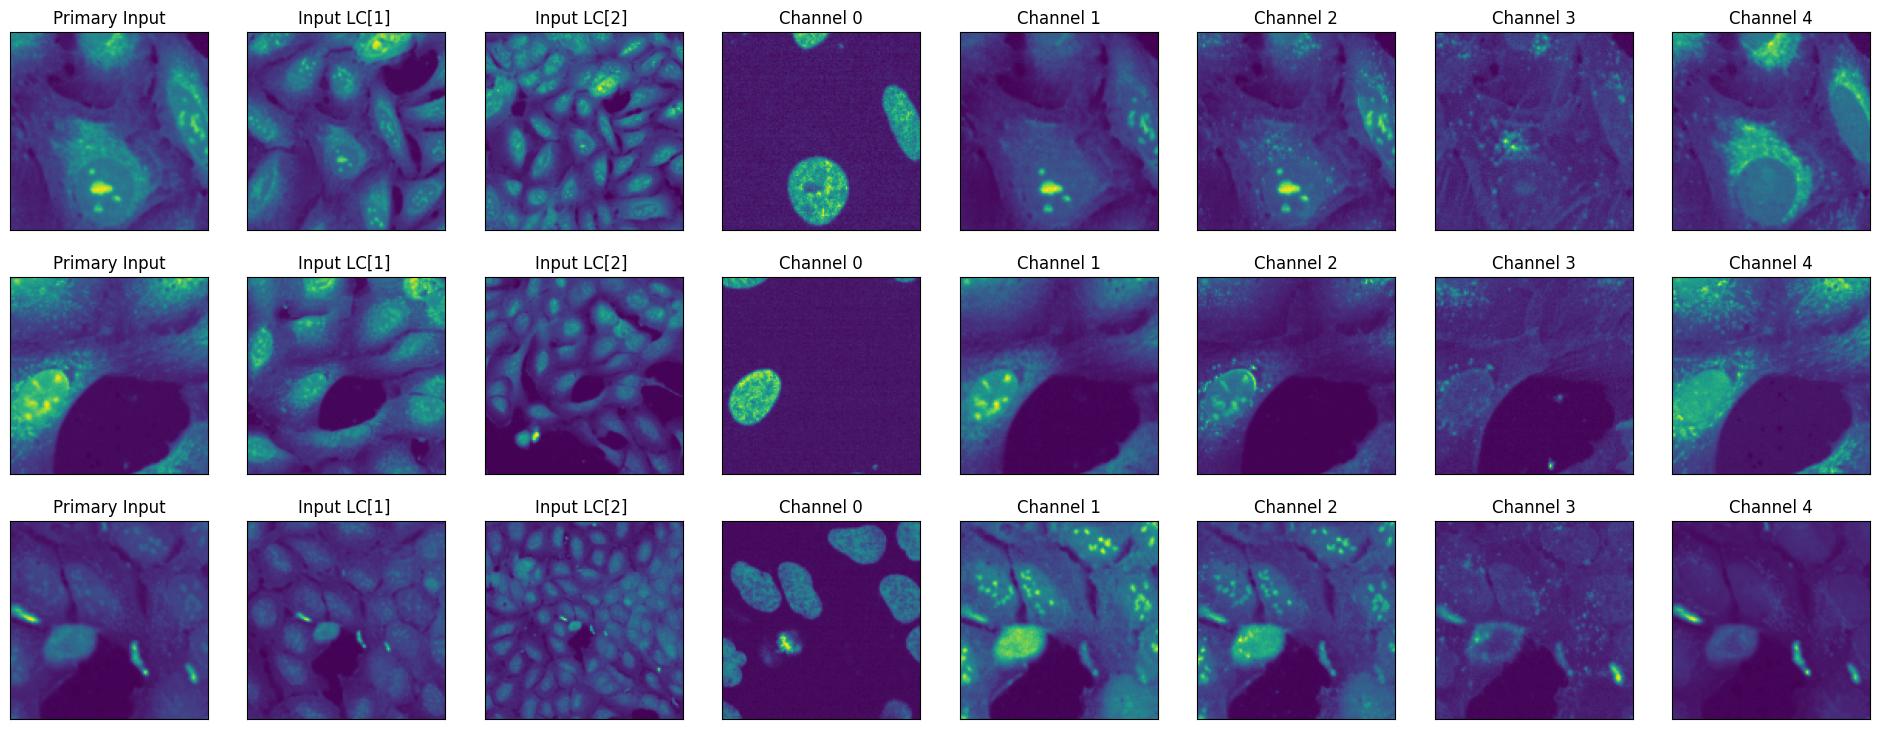

In [22]:
# Plot some sample patches from the training data
sample_indices = plot_input_patches(dataset=train_dset, num_channels=len(TARGET_CHANNEL_LIST), num_samples=3, patch_size=128)
print(f"Sample indices: {sample_indices}")

## Step 7: Now we are ready to train the model!

In [23]:
# Define a checkpoint directory for this specific run
checkpoint_dir = os.path.join("./checkpoints/10_all_channels_dataset")
os.makedirs(checkpoint_dir, exist_ok=True)

# Create a CAREamics 'Trainer'
trainer = Trainer(
    max_epochs=training_config.num_epochs,
    accelerator="gpu",
    enable_progress_bar=True,
    callbacks=get_callbacks(checkpoint_dir),
    precision=training_config.precision,
    gradient_clip_val=training_config.gradient_clip_val,
    gradient_clip_algorithm=training_config.gradient_clip_algorithm,
)

# Start the training
trainer.fit(
    model=model,
    train_dataloaders=train_dloader,
    val_dataloaders=val_dloader,
)

print("Training complete!")

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/localscratch/mambaforge/envs/microsplit/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA A40-16Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type                

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/localscratch/mambaforge/envs/microsplit/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/localscratch/mambaforge/envs/microsplit/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/localscratch/mambaforge/envs/microsplit/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
Metric val_loss improved. New best score: 6.370


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.172 >= min_delta = 1e-06. New best score: 6.197


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 1e-06. New best score: 6.183


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.100 >= min_delta = 1e-06. New best score: 6.083


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.097 >= min_delta = 1e-06. New best score: 5.986


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.052 >= min_delta = 1e-06. New best score: 5.934


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 1e-06. New best score: 5.919
`Trainer.fit` stopped: `max_epochs=10` reached.


Training complete!


## Let's look at the training loss curves from the training

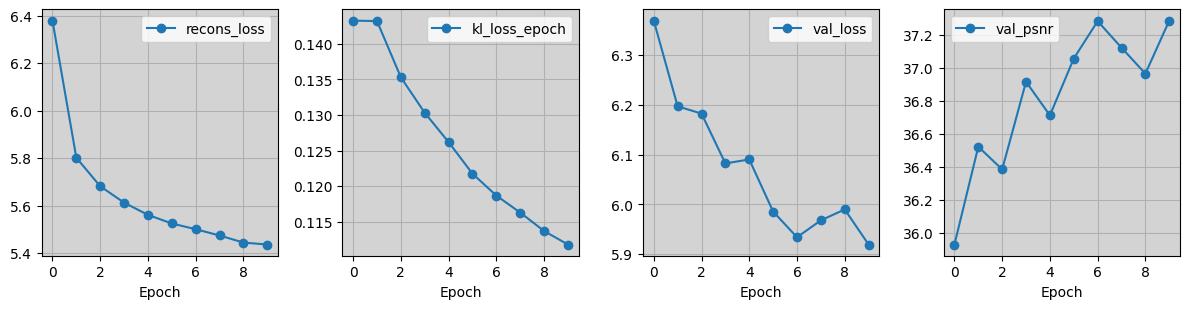

In [24]:
from pandas import read_csv
from microsplit_reproducibility.notebook_utils.JUMP import find_recent_metrics, plot_metrics

# Create a custom find_recent_metrics function if not available for JUMP
def find_recent_metrics():
    import glob
    log_dirs = sorted(glob.glob("./lightning_logs/version_*"))
    if log_dirs:
        return f"{log_dirs[-1]}/metrics.csv"
    return None

# Plot metrics
metrics_file = find_recent_metrics()
if metrics_file:
    df = read_csv(metrics_file)
    # Use plot_metrics function from notebook_utils if available
    # Otherwise use a simplified version
    try:
        from microsplit_reproducibility.notebook_utils.HT_LIF24 import plot_metrics
        plot_metrics(df)
    except ImportError:
        # Simplified version
        fig, ax = plt.subplots(figsize=(12,3), ncols=4)
        df['reconstruction_loss_epoch'].dropna().reset_index(drop=True).plot(ax=ax[0], marker='o')
        df['kl_loss_epoch'].dropna().reset_index(drop=True).plot(ax=ax[1], marker='o')
        df['val_loss'].dropna().reset_index(drop=True).plot(ax=ax[2], marker='o')
        df['val_psnr'].dropna().reset_index(drop=True).plot(ax=ax[3], marker='o')
        plt.tight_layout()

Now we can move onto the next step, we will do predictions in the 03JUMP_microsplit notebook.